In [ ]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Vertex AI Model Garden - LLaMA2 (PEFT)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
Open in Vertex AI Workbench
    </a> (A Python-3 CPU notebook is recommended)
  </td>
</table>

## Overview

This notebook demonstrates deploying prebuilt LLaMA2 models, and also finetuning and deploying LLaMA2 models with performance efficient finetuning libraries ([PEFT](https://github.com/huggingface/peft)) in Vertex AI. This notebook also uses [Text moderation APIs](https://cloud.google.com/natural-language/docs/moderating-text) to analyze predictions against a list of safety attributes

### Objective

- Deploy prebuilt LLaMA2 models
- Finetune and deploy LLaMA2 models with PEFT
- Deploy LLaMA2 with [vLLM](https://github.com/vllm-project/vllm) to improve serving throughput

### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage pricing](https://cloud.google.com/storage/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Before you begin

### Colab only
Run the following commands for Colab and skip this section if you are using Workbench.

In [ ]:
import sys

if "google.colab" in sys.modules:
    ! pip3 install --upgrade google-cloud-aiplatform
    ! pip3 install ipython pandas[output_formatting] google-cloud-language==2.10.0
    from google.colab import auth as google_auth

    google_auth.authenticate_user()
    # Install gdown for downloading example training images.
    ! pip3 install gdown

    # Restart the notebook kernel after installs.
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Setup Google Cloud project

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API, Compute Engine API and Cloud Natural Language API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,language.googleapis.com).

1. [Create a Cloud Storage bucket](https://cloud.google.com/storage/docs/creating-buckets) for storing experiment outputs.

1. [Create a service account](https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console) with `Vertex AI User` and `Storage Object Admin` roles for deploying fine tuned model to Vertex AI endpoint.

Fill following variables for experiments environment:

In [ ]:
# Cloud project id.
PROJECT_ID = ""  # @param {type:"string"}

# The region you want to launch jobs in.
REGION = ""  # @param {type:"string"}

# The Cloud Storage bucket for storing experiments output.
BUCKET_URI = ""  # @param {type:"string"}

! gcloud config set project $PROJECT_ID
! gcloud services enable language.googleapis.com

import os

STAGING_BUCKET = os.path.join(BUCKET_URI, "temporal")
EXPERIMENT_BUCKET = os.path.join(BUCKET_URI, "peft")
DATA_BUCKET = os.path.join(EXPERIMENT_BUCKET, "data")
BASE_MODEL_BUCKET = os.path.join(EXPERIMENT_BUCKET, "base_model")
MODEL_BUCKET = os.path.join(EXPERIMENT_BUCKET, "model")
PREDICTION_BUCKET = os.path.join(EXPERIMENT_BUCKET, "prediction")

# The service account looks like:
# '@.iam.gserviceaccount.com'
# Please go to https://cloud.google.com/iam/docs/service-accounts-create#iam-service-accounts-create-console
# and create service account with `Vertex AI User` and `Storage Object Admin` roles.
# The service account for deploying fine tuned model.
SERVICE_ACCOUNT = ""  # @param {type:"string"}

from google.colab import auth

auth.authenticate_user(project_id=PROJECT_ID)

### Initialize Vertex AI API

In [ ]:
from google.cloud import aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=STAGING_BUCKET)

### Define constants

In [ ]:
# The pre-built training and serving docker images.
TRAIN_DOCKER_URI = (
    "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-peft-train"
)
PREDICTION_DOCKER_URI = (
    "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-peft-serve"
)
VLLM_DOCKER_URI = (
    "us-docker.pkg.dev/vertex-ai/vertex-vision-model-garden-dockers/pytorch-vllm-serve"
)

### Define common functions

In [ ]:
import os
from datetime import datetime

from google.cloud import aiplatform, language


def get_job_name_with_datetime(prefix: str):
    """Gets the job name with date time when triggering training or deployment
    jobs in Vertex AI.
    """
    return prefix + datetime.now().strftime("_%Y%m%d_%H%M%S")


def deploy_model(
    model_name,
    base_model_id,
    finetuned_lora_model_path,
    service_account,
    task,
    precision_loading_mode="float16",
    machine_type="n1-standard-8",
    accelerator_type="NVIDIA_TESLA_V100",
    accelerator_count=1,
):
    """Deploys trained models into Vertex AI."""
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")
    serving_env = {
        "BASE_MODEL_ID": base_model_id,
        "PRECISION_LOADING_MODE": precision_loading_mode,
        "TASK": task,
    }
    if finetuned_lora_model_path:
        serving_env["FINETUNED_LORA_MODEL_PATH"] = finetuned_lora_model_path
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=PREDICTION_DOCKER_URI,
        serving_container_ports=[7080],
        serving_container_predict_route="/predictions/peft_serving",
        serving_container_health_route="/ping",
        serving_container_environment_variables=serving_env,
    )
    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        deploy_request_timeout=1800,
        service_account=service_account,
    )
    return model, endpoint


def deploy_model_vllm(
    model_name,
    model_id,
    service_account,
    machine_type="n1-standard-8",
    accelerator_type="NVIDIA_TESLA_V100",
    accelerator_count=1,
):
    """Deploys trained models with vLLM into Vertex AI."""
    endpoint = aiplatform.Endpoint.create(display_name=f"{model_name}-endpoint")

    vllm_args = [
        "--host=0.0.0.0",
        "--port=7080",
        f"--model={model_id}",
        f"--tensor-parallel-size={accelerator_count}",
        "--swap-space=16",
        "--gpu-memory-utilization=0.95",
        "--disable-log-stats",
    ]
    model = aiplatform.Model.upload(
        display_name=model_name,
        serving_container_image_uri=VLLM_DOCKER_URI,
        serving_container_command=["python", "-m", "vllm.entrypoints.api_server"],
        serving_container_args=vllm_args,
        serving_container_ports=[7080],
        serving_container_predict_route="/generate",
        serving_container_health_route="/ping",
    )

    model.deploy(
        endpoint=endpoint,
        machine_type=machine_type,
        accelerator_type=accelerator_type,
        accelerator_count=accelerator_count,
        deploy_request_timeout=1800,
        service_account=service_account,
    )
    return model, endpoint


def moderate_text(text: str) -> language.ModerateTextResponse:
    """Calls Vertex AI APIs to analyze text moderations."""
    client = language.LanguageServiceClient()
    document = language.Document(
        content=text,
        type_=language.Document.Type.PLAIN_TEXT,
    )
    return client.moderate_text(document=document)


def show_text_moderation(text: str, response: language.ModerateTextResponse):
    """Shows text moderation results."""
    import pandas as pd

    def confidence(category: language.ClassificationCategory) -> float:
        return category.confidence

    columns = ["category", "confidence"]
    categories = sorted(response.moderation_categories, key=confidence, reverse=True)
    data = ((category.name, category.confidence) for category in categories)
    df = pd.DataFrame(columns=columns, data=data)

    print(f"Text analyzed:\n{text}")
    print(df.to_markdown(index=False, tablefmt="presto", floatfmt=".0%"))

## Access LLaMA2 pretrained and finetuned models
The original models from Meta are converted into the Hugging Face format for finetuning and serving in Vertex AI.
After clicking the agreement of LLaMA2 in Vertex AI Model Garden, a Cloud Storage bucket will be shared to access LLaMA2 pretrained and finetuned models.

In [ ]:
VERTEX_AI_MODEL_GARDEN_LLAMA2 = ""  # This will be shared once click the agreement of LLaMA2 in Vertex AI Model Garden.
assert (
    VERTEX_AI_MODEL_GARDEN_LLAMA2
), "Please click the agreement of LLaMA2 in Vertex AI Model Garden, and get the GCS path of LLaMA2 model artifacts."
print(
    "Copy LLaMA2 model artifacts from",
    VERTEX_AI_MODEL_GARDEN_LLAMA2,
    "to ",
    BASE_MODEL_BUCKET,
)
! gsutil -m cp -R $VERTEX_AI_MODEL_GARDEN_LLAMA2/* $BASE_MODEL_BUCKET

Set the base model id.

In [ ]:
base_model_name = "llama2-7b-chat-hf"  # @param ["llama2-7b-hf", "llama2-7b-chat-hf", "llama2-13b-hf", "llama2-13b-chat-hf", "llama2-70b-hf", "llama2-70b-chat-hf"]
base_model_id = "gs://" + os.path.join(BASE_MODEL_BUCKET, base_model_name)

## Deploy prebuilt LLaMA2 models

This section deploys prebuilt LLaMA2 models on Vertex AI.

You use the PEFT serving images to deploy prebuilt LLaMA2 models, by setting finetuning LoRA model paths as empty. The model deployment step will take 15 minutes to 1 hour to complete, depending on the model sizes.

In [ ]:
# Sets V100 to deploy LLaMA2 7B.
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Sets A100 (40G) to deploy LLaMA2 13B.
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Sets 4 A100 (40G) to deploy LLaMA2 70B models.
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

# The supported precision loading types are "4bit", "8bit", "float16" and "float32".
# Quantization on prebuilt models directly might get poor results.
# Suggests to use float16 for prebuild LLaMA2 model deployments.
precision_loading_mode = "float16"

model_without_peft, endpoint_without_peft = deploy_model(
    model_name=get_job_name_with_datetime(prefix="llama2-serve"),
    base_model_id=base_model_id,
    finetuned_lora_model_path="",  # This will avoid override finetuning models.
    service_account=SERVICE_ACCOUNT,
    task="causal-language-modeling-lora",
    precision_loading_mode=precision_loading_mode,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
)
print("endpoint_name:", endpoint_without_peft.name)

NOTE: The prebuilt model weights will be downloaded on the fly from $BASE_MODEL_BUCKET after the deployment succeeds. Thus additional 10 ~ 40 minutes (depending on the model sizes) of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

Once deployment succeeds, you can send requests to the endpoint with text prompts.

Example:

```
Human: What is a car?
Assistant:  A car, or a motor car, is a road-connected human-transportation system used to move people or goods from one place to another. The term also encompasses a wide range of vehicles, including motorboats, trains, and aircrafts. Cars typically have four wheels, a cabin for passengers, and an engine or motor. They have been around since the early 19th century and are now one of the most popular forms of transportation, used for daily commuting, shopping, and other purposes.
```

In [ ]:
# Loads an existing endpoint as below.
endpoint_name = endpoint_without_peft.name
aip_endpoint_name = (
    f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint_name}"
)
endpoint_without_peft = aiplatform.Endpoint(aip_endpoint_name)
# Overides max_length and top_k parameters during inferences.
# If you encounter the issue like `ServiceUnavailable: 503 Took too long to respond when processing`,
# you can reduce the max length, such as set max_length as 20.
instances = [
    {"prompt": "Write a poem about Valencia.", "max_length": 200, "top_k": 10},
]
response = endpoint_without_peft.predict(instances=instances)

for prediction in response.predictions[0]:
    print(prediction["generated_text"])

Text moderation analyzes a document against a list of safety attributes, which include "harmful categories" and topics that may be considered sensitive.

In [ ]:
for prediction in response.predictions[0]:
    generated_text = prediction["generated_text"]
    # Send a request to the API.
    response = moderate_text(generated_text)

    # Show the results.
    show_text_moderation(generated_text, response)

## Deploy Prebuilt LLaMA2 with vLLM

This section deploys prebuilt OpenLLaMA models with [vLLM](https://github.com/vllm-project/vllm) on the Endpoint. The model deployment step will take ~15 minutes to complete.

vLLM is an highly optimized LLM serving framework which can increase serving throughput a lot. The higher QPS you have, the more benefits you get using vLLM.

In [ ]:
# Sets V100 to deploy LLaMA2 7B.
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Sets A100 (40G) to deploy LLaMA2 13B.
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Sets 4 A100 (40G) to deploy LLaMA2 70B models.
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

model_without_peft_vllm, endpoint_without_peft_vllm = deploy_model_vllm(
    model_name=get_job_name_with_datetime(prefix="llama2-serve-vllm"),
    model_id=base_model_id,
    service_account=SERVICE_ACCOUNT,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
)

NOTE: The prebuilt model weights will be downloaded on the fly from the orginal location after the deployment succeeds. Thus additional 5 minutes of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

Once deployment succeeds, you can send requests to the endpoint with text prompts.

In [ ]:
instance = {
    "prompt": "Hi, Google."
    "n": 1,
    "max_tokens": 32,
}
response = endpoint_without_peft_vllm.predict(instances=[instance])
print(response.predictions[0])

## Finetune and deploy LLaMA2 models with PEFT

This section demonstrates how to finetune and deploy LLaMA2 models with PEFT LoRA.

### Finetune

Use the Vertex AI SDK to create and run the custom training jobs with Vertex AI Model Garden training images.

This example uses the dataset [Abirate/english_quotes](https://huggingface.co/datasets/Abirate/english_quotes).

In [ ]:
dataset_name = "Abirate/english_quotes"  # @param {type:"string"}
finetuning_precision_mode = "float16"

# Worker pool spec.
# Finetunes LLaMA2 7B with 1 V100 (16G).
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Finetunes and LLaMA2 13B with 1 A100 (40G).
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Finetunes and LLaMA2 70B with 4 A100 (40G).
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

replica_count = 1


# Setup training job.
job_name = get_job_name_with_datetime("llama2-lora-train")
train_job = aiplatform.CustomContainerTrainingJob(
    display_name=job_name,
    container_uri=TRAIN_DOCKER_URI,
)
output_dir = os.path.join(MODEL_BUCKET, job_name)
output_dir_gcsfuse = output_dir.replace("gs://", "/gcs/")

# Pass training arguments and launch job.
train_job.run(
    args=[
        "--task=causal-language-modeling-lora",
        f"--pretrained_model_id={base_model_id}",
        f"--dataset_name={dataset_name}",
        f"--output_dir={output_dir_gcsfuse}",
        "--lora_rank=16",
        "--lora_alpha=32",
        "--lora_dropout=0.05",
        "--warmup_steps=10",
        "--max_steps=10",
        "--learning_rate=2e-4",
        f"--precision_mode={finetuning_precision_mode}",
    ],
    replica_count=replica_count,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
    boot_disk_size_gb=500,
)

print("Trained models were saved in: ", output_dir)

### Deploy
This section uploads the model to Model Registry and deploys it on the Endpoint.

The model deployment step will take 15 minutes to 1 hour to complete, depending on the model sizes.

In [ ]:
# Sets V100 to deploy LLaMA2 7B.
machine_type = "n1-standard-8"
accelerator_type = "NVIDIA_TESLA_V100"
accelerator_count = 1

# Sets A100 (40G) to deploy LLaMA2 13B.
# machine_type = "a2-highgpu-1g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 1

# Sets 4 A100 (40G) to deploy LLaMA2 70B models.
# machine_type = "a2-highgpu-4g"
# accelerator_type = "NVIDIA_TESLA_A100"
# accelerator_count = 4

# The supported precision loading types are "4bit", "8bit", "float16" and "float32".
precision_loading_mode = finetuning_precision_mode

model_with_peft, endpoint_with_peft = deploy_model(
    model_name=get_job_name_with_datetime(prefix="llama2-peft-serve"),
    base_model_id=base_model_id,
    finetuned_lora_model_path=output_dir,
    service_account=SERVICE_ACCOUNT,
    task="causal-language-modeling-lora",
    precision_loading_mode=precision_loading_mode,
    machine_type=machine_type,
    accelerator_type=accelerator_type,
    accelerator_count=accelerator_count,
)
print("endpoint_name:", endpoint_with_peft.name)

NOTE: After the deployment succeeds, the base model weights will be downloaded on the fly from $BASE_MODEL_BUCKET and LoRA model weights will be downloaded from the GCS bucket used in training above. Thus additional 10 ~ 40 minutes (depending on the model sizes) of waiting time is needed **after** the above model deployment step succeeds and before you run the next step below. Otherwise you might see a `ServiceUnavailable: 503 502:Bad Gateway` error when you send requests to the endpoint.

Once deployment succeeds, you can send requests to the endpoint with text prompts.

Example:

```
Human: What is a car?
Assistant:  A car, or a motor car, is a road-connected human-transportation system used to move people or goods from one place to another. The term also encompasses a wide range of vehicles, including motorboats, trains, and aircrafts. Cars typically have four wheels, a cabin for passengers, and an engine or motor. They have been around since the early 19th century and are now one of the most popular forms of transportation, used for daily commuting, shopping, and other purposes.
```

In [ ]:
# Loads an existing endpoint as below.
endpoint_name = endpoint_with_peft.name
aip_endpoint_name = (
    f"projects/{PROJECT_ID}/locations/{REGION}/endpoints/{endpoint_name}"
)
endpoint_with_peft = aiplatform.Endpoint(aip_endpoint_name)
# Overides max_length and top_k parameters during inferences.
# If you encounter the issue like `ServiceUnavailable: 503 Took too long to respond when processing`,
# you can reduce the max length, such as set max_length as 20.
instances = [
    {"prompt": "What is a car?", "max_length": 200, "top_k": 10},
]
response = endpoint_with_peft.predict(instances=instances)

for prediction in response.predictions[0]:
    print(prediction["generated_text"])

Text moderation analyzes a document against a list of safety attributes, which include "harmful categories" and topics that may be considered sensitive.

In [ ]:
for prediction in response.predictions[0]:
    generated_text = prediction["generated_text"]
    # Send a request to the API.
    response = moderate_text(generated_text)

    # Show the results.
    show_text_moderation(generated_text, response)

## Clean up resources

In [ ]:
# Delete custom train jobs.
train_job.delete()

# Undeploy model and delete endpoint.
endpoint_without_peft.delete(force=True)
endpoint_with_peft.delete(force=True)
endpoint_without_peft_vllm.delete(force=True)

# Delete models.
model_without_peft.delete()
model_with_peft.delete()
model_without_peft_vllm.delete()

# Delete Cloud Storage objects that were created
delete_bucket = False
if delete_bucket:
    ! gsutil -m rm -r $EXPERIMENT_BUCKET

# Vertex AI Model Garden - LLaMA2 (RLHF)

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
        <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
    <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/community/model_garden/model_garden_pytorch_llama2_peft.ipynb">
       <img src="https://www.gstatic.com/cloud/images/navigation/vertex-ai.svg" alt="Vertex AI logo">Open in Vertex AI Workbench
    </a>
</table>

## Overview

This tutorial demonstrates how to use Vertex AI RLHF to tune a LLaMA2. This workflow improves a model's accuracy by fine-tuning a base model with a training dataset.


### Objective

In this tutorial, you will use `Vertex AI RLHF` to tune a large language model model, perform bulk inference and model deployment.


This tutorial uses the following Google Cloud ML services:

- `Vertex AI RLHF`
- `Vertex AI Pipelines`


The steps performed include:

- Set the number of model tuning steps.
- Create Vertex AI Pipeline job using a predefined template for tuning.
- Execute the pipeline using `Vertex AI Pipelines`.
- Perform online prediction with the tuned model.

### Prepare your inputs

In the sample below, you will run RLHF training on LLaMA 2 70B chat model. A list of supported models, hardware and regions can be found as follows. Tuning jobs that run in us-central1 will use 8 Nvidia A100 80GB. Jobs that run in europe-west4 will use 64 v3 TPUs.

**Table 1. Supported models, hardware and regions**

| large_model_reference | supported accelerator_type | supported region |
|---|---|---|
|  `llama-2-7b` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `llama-2-7b-chat` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `llama-2-13b` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |
|  `llama-2-13b-chat` | `TPU_V3`, `NVIDIA_TESLA_A100` | europe-west4, us-central1 |

The workflow takes the following inputs:

* **preference_dataset**: Required, `str`. Cloud storage path to a human preference dataset used to train a reward model. Download the [example dataset](https://pantheon.corp.google.com/storage/browser/vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=vertex-ai&prefix=&forceOnObjectsSortingFiltering=false), and see its content.
> The dataset format is `jsonl`. Each line in the file contains one example:
> * An `input_text` field containing the prompt.
> * `candidate_0`, `candidate_1` fields containing the candidate responses.
> * A `choice` field that specifies which candidate is preferred. This field is an integer `0` or `1`. `0` means `candidate_0` is preferred, `1` means `candidate_1` is preferred.
> * For example: `{"input_text": "Create a description for Plantation Palms.", "candidate_0": "Enjoy some fun in the sun at Gulf Shores.", "candidate_1": "A Tranquil Oasis of Natural Beauty.", "choice": 0}`

* **prompt_dataset**: Required, `str`. Cloud storage path to an unlabled prompt dataset used for reinforcement learning. Download the [example dataset](https://pantheon.corp.google.com/storage/browser/vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&e=13802955&jsmode=O&mods=-ai_platform_fake_service&project=vertex-ai&prefix=&forceOnObjectsSortingFiltering=false), and see its content.
> The dataset format is `jsonl`. Each line in the file contains one example:
> * An `input_text` field containing the prompt.
> * For example: `{"input_text": "Create a description for Plantation Palms."}`

* **eval_dataset**: Optional, `str`. Cloud storage path to the unlabeled dataset you want to do prediction on. If provided, inference will be performed on this dataset after training. Its format is exactly the same as **prompt_dataset**.

* **large_model_reference**: Required, `str`. Name of the base model. In this example, we use `text-bison@001`. Valid values are listed in the table above.

* **model_display_name**: Optional, `str`. Name of the fine-tuned model shown in the Model Registry. If not provided, a default name will be created.

* **reward_model_train_steps**: Optional, `int`. Number of steps to use when training a reward model. Default value is 1000.

* **reinforcement_learning_train_steps**: Optional, `int`. Number of reinforcement learning steps to perform when tuning a base model. Default value is 1000.

* **prompt_sequence_length**: Optional, `int`. Maximum tokenized sequence length for input text. Higher values increase memory overhead. This value should be at most `8192`. Default value is `512`.

* **target_sequence_length**: Optional, `int`. Maximum tokenized sequence length for target text. Higher values increase memory overhead. This value should be at most `1024`. Default value is `64`.

* **reward_model_learning_rate_multiplier**: Optional, `float`. Constant used to adjust the base learning rate used when training a reward model. Multiply by a number > 1 to increase the magnitude of updates applied at each training step or multiply by a number < 1 to decrease the magnitude of updates. Default value is `1.0`.

* **reinforcement_learning_rate_multiplier**: Optional, `float`. Constant used to adjust the base learning rate used during reinforcement learning. Multiply by a number > 1 to increase the magnitude of updates applied at each training step or multiply by a number < 1 to decrease the magnitude of updates. Default value is `1.0`.

* **kl_coeff**: Optional, `float`. Coefficient for KL penalty. This regularizes the policy model and penalizes if it diverges from its initial distribution. If set to 0, the reference language model is not loaded into memory. Default value is `0.1`.

* **lora_dim**: Optional, `int`. Default value is 4. If set to 0, full-model tuning is performed.

* **instruction**: Optional, `str`. This field lets the model know what task it needs to perform. Base models have been trained over a large set of varied instructions. You can give a simple and intuitive description of the task and the model will follow it, e.g. `Classify this movie review as positive or negative` or `Translate this sentence to Danish`. See [here](https://ai.googleblog.com/2021/10/introducing-flan-more-generalizable.html) for more details on the instruction-tuned models. Do not specify this if your dataset already prepends the instruction to the inputs field.

### A Note on choosing train_steps

Choosing a suitable value for the number of train steps can help avoid overfitting.

* **reward_model_train_steps**: This depends on the size of your "comparison dataset". Usually, the model should train over the comparison dataset for 20-30 times for best results.

* **reinforcement_learning_train_steps**: This depends on the size of your prompt dataset. Usually, the model should train over the prompt dataset for roughly 10-20 times, but beware, if given too many training steps, the policy model may figure out a way exploit the reward and exhibit undesired behavior (i.e. "reward hacking").

The calculator below can help you compute these numbers.

In [ ]:
# Please REPLACE with your own parameters for:
# - N_COMPARISON_DATASET_EXAMPLES
# - N_REWARD_MODEL_TRAINER_EPOCHS
# - N_PROMPT_DATASET_EXAMPLES
# - N_REINFORCER_EPOCHS
# - BATCH_SIZE

import math

# This is your "preference dataset" size.
N_PREFERENCE_DATASET_EXAMPLES = 3000
# An epoch refers to one full cycle through the training dataset.
N_REWARD_MODEL_TRAIN_EPOCHS = 30

# This is your "prompt dataset" size.
N_PROMPT_DATASET_EXAMPLES = 2000
# An epoch refers to one full cycle through the training dataset.
N_REINFORCEMENT_LEARNING_TRAIN_EPOCHS = 10

BATCH_SIZE = 64  # We use fixed batch_size=64 under the hood.

reward_model_train_steps = math.ceil(
    N_PREFERENCE_DATASET_EXAMPLES * N_REWARD_MODEL_TRAIN_EPOCHS / BATCH_SIZE
)  # 3000 * 30 / 64 = 1407

reinforcement_learning_train_steps = math.ceil(
    N_PROMPT_DATASET_EXAMPLES * N_REINFORCEMENT_LEARNING_TRAIN_EPOCHS / BATCH_SIZE
)  # 2000 * 10 / 64 = 313

print(f"{reward_model_train_steps=}")
print(f"{reinforcement_learning_train_steps=}")

reward_model_train_steps=1407
reinforcement_learning_train_steps=313


### Costs

This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Installation

Install the following packages required to execute this notebook.

In [ ]:
! pip3 install --upgrade --quiet google-cloud-aiplatform google-cloud-pipeline-components kfp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372.4 kB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.0/321.0 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 10.5 MB/s eta 0:00:00


### Colab only: Uncomment the following cell to restart the kernel

Automatically restart kernel after installs so that your environment can access the new packages

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Before you begin

### Set your project ID

**If you don't know your project ID**, try the following:
* Run `gcloud config list`.
* Run `gcloud projects list`.
* See the support page: [Locate the project ID](https://support.google.com/googleapi/answer/7014113)

In [ ]:
PROJECT_ID = "llm-experiment-393119"  # @param {type:"string"}

# Set the project id
! gcloud config set project {PROJECT_ID}

Updated property [core/project].


#### Region

You can also change the `REGION` variable used by Vertex AI. For preview, only `us-central1` and `europe-west4` are supported.

In [ ]:
REGION = "europe-west4"

### Authenticate your Google Cloud account

Depending on your Jupyter environment, you may need to authenticate manually. Follow the relevant instructions below.

#### Vertex AI Workbench
Do nothing as you are already authenticated.

#### Local JupyterLab instance

**1. Uncomment and run:**

In [ ]:
! gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fsdk.cloud.google.com%2Fauthcode.html&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=1yxKvgmHPgiw8yrdxnpPOSEOmj51k1&prompt=consent&access_type=offline&code_challenge=HPgspkyt99l8KNlftRP6QbFVCTnxWGmbL3IRC5wwjaY&code_challenge_method=S256

Enter authorization code: 

**2. Colab, uncomment and run:**

In [ ]:
from google.colab import auth

auth.authenticate_user()

**3. Service account or other**
* See how to grant Cloud Storage permissions to your service account at https://cloud.google.com/storage/docs/gsutil/commands/iam#ch-examples.

### Create a Cloud Storage bucket

Define a storage bucket to store pipeline artifacts.

In [ ]:
BUCKET_URI = f"gs://your-bucket-name-{PROJECT_ID}-unique"  # @param {type:"string"}

**Only if your bucket doesn't exist already**: Run the following cell to create your Cloud Storage bucket.

In [ ]:
! gsutil mb -l $REGION -p $PROJECT_ID $BUCKET_URI

#### Service Account

A service account is needed to create Vertex AI Pipeline jobs. If you don't know your service account, try to get your service account using gcloud command by executing the second cell below.

In [ ]:
SERVICE_ACCOUNT = "[your-service-account]"  # @param {type:"string"}

In [ ]:
import sys

IS_COLAB = "google.colab" in sys.modules
if (
    SERVICE_ACCOUNT == ""
    or SERVICE_ACCOUNT is None
    or SERVICE_ACCOUNT == "[your-service-account]"
):
    # Get your service account from gcloud
    if not IS_COLAB:
        shell_output = !gcloud auth list 2>/dev/null
        SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

    else:  # IS_COLAB:
        shell_output = ! gcloud projects describe  $PROJECT_ID
        project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
        SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

    print("Service Account:", SERVICE_ACCOUNT)

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step. You only need to run this step once per service account.

In [ ]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [ ]:
import google.cloud.aiplatform as aiplatform

aiplatform.init(project=PROJECT_ID, location=REGION, staging_bucket=BUCKET_URI)

## Construct the Pipeline Job and Run on Vertex AI

Define a pipeline job with the following code, which will:

- load the pipeline template that was compiled in the previous step, and
- set pipeline parameters. (See [Prepare your inputs](https://colab.research.google.com/drive/1SGSTAW3dcANbU_d3g5mSGCN9LXf5cA1p?resourcekey=0-NAfp-Rrb9piBiJbvqa6bqA#scrollTo=aef4f59195ad&line=61&uniqifier=1) section above for the definition of these parameters.)


In [ ]:
# Create a job via the pipeline template compiled in the previous step:
job = aiplatform.PipelineJob(
    display_name="tutorial-rlhf-tuning",
    pipeline_root=f"{BUCKET_URI}/rlhf",
    template_path="https://us-kfp.pkg.dev/ml-pipeline/llm-rlhf/rlhf-llama-train-template/stable",
    parameter_values={
        "preference_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/summarize_from_feedback_tfds/comparisons/train/*.jsonl",
        "prompt_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/train/*.jsonl",
        "eval_dataset": "gs://vertex-ai/generative-ai/rlhf/text_small/reddit_tfds/val/*.jsonl",
        "large_model_reference": "llama-2-7b-chat",  # see Table 1 for valid values.
        "model_display_name": "my_rlhf_tutorial_model",  # Optional. If omitted, a default model_display_name will be created.
        "reward_model_train_steps": 100,  # Please remember to read "A Note on choosing train_steps" section.
        "reinforcement_learning_train_steps": 100,  # Please remember to read "A Note on choosing train_steps" section.
        "prompt_sequence_length": 512,
        "target_sequence_length": 64,
        "reward_model_learning_rate_multiplier": 1.0,
        "reinforcement_learning_rate_multiplier": 1.0,
        "kl_coeff": 0.1,
        "lora_dim": 4,
        "instruction": "Summarize in less than 50 words.",
    },
)

### Run the pipeline using Vertex AI Pipelines

Execute the following cell to run the pipeline on Vertex AI.

In [ ]:
job.run()

### View pipeline job in UI

Go to "Vertex AI Pipelines" in the Google Cloud UI to view the pipeline job. When the pipeline completes, click on the **Reinforcer** step. In the output parameters section you should see the output model's GCS path.
* If you tuned an open-source model (like the T5 models), the output model will be in your project's GCS buckets. You will be able to download the tuned model.
* If you tuned PaLM 2 models, the output model will be in a restricted-access GCS bucket. You won't be able to download the tuned model.

### Look at training loss and reward using Tensorboard

The **RewardModelTrainer** and **Reinforcer** output the training time `rank_loss`, `reward`, `kl_loss` to tensorboard to help you examine training curves and decide how to tune hyper-parameters.

Click on the **tensorboard_metrics** > `URI` attached to **RewardModelTrainer** and **Reinforcer**. If you encounter "❗ Requested entity was not found", this is a known issue. Hit the backarrow at the top of the page, then > `tensorboard_metrics/` > `train/` > some filename that looks like `events.out.tfevents.*-w-1.1.0.v2`. This is the tensorboard file. Download the tensorboard files from both RewardModelTrainer and Reinforcer.

Visualize the tensorboards using the [tensorboard python package](https://pypi.org/project/tensorboard/). It will give you some loss curves that looks like the curves below.


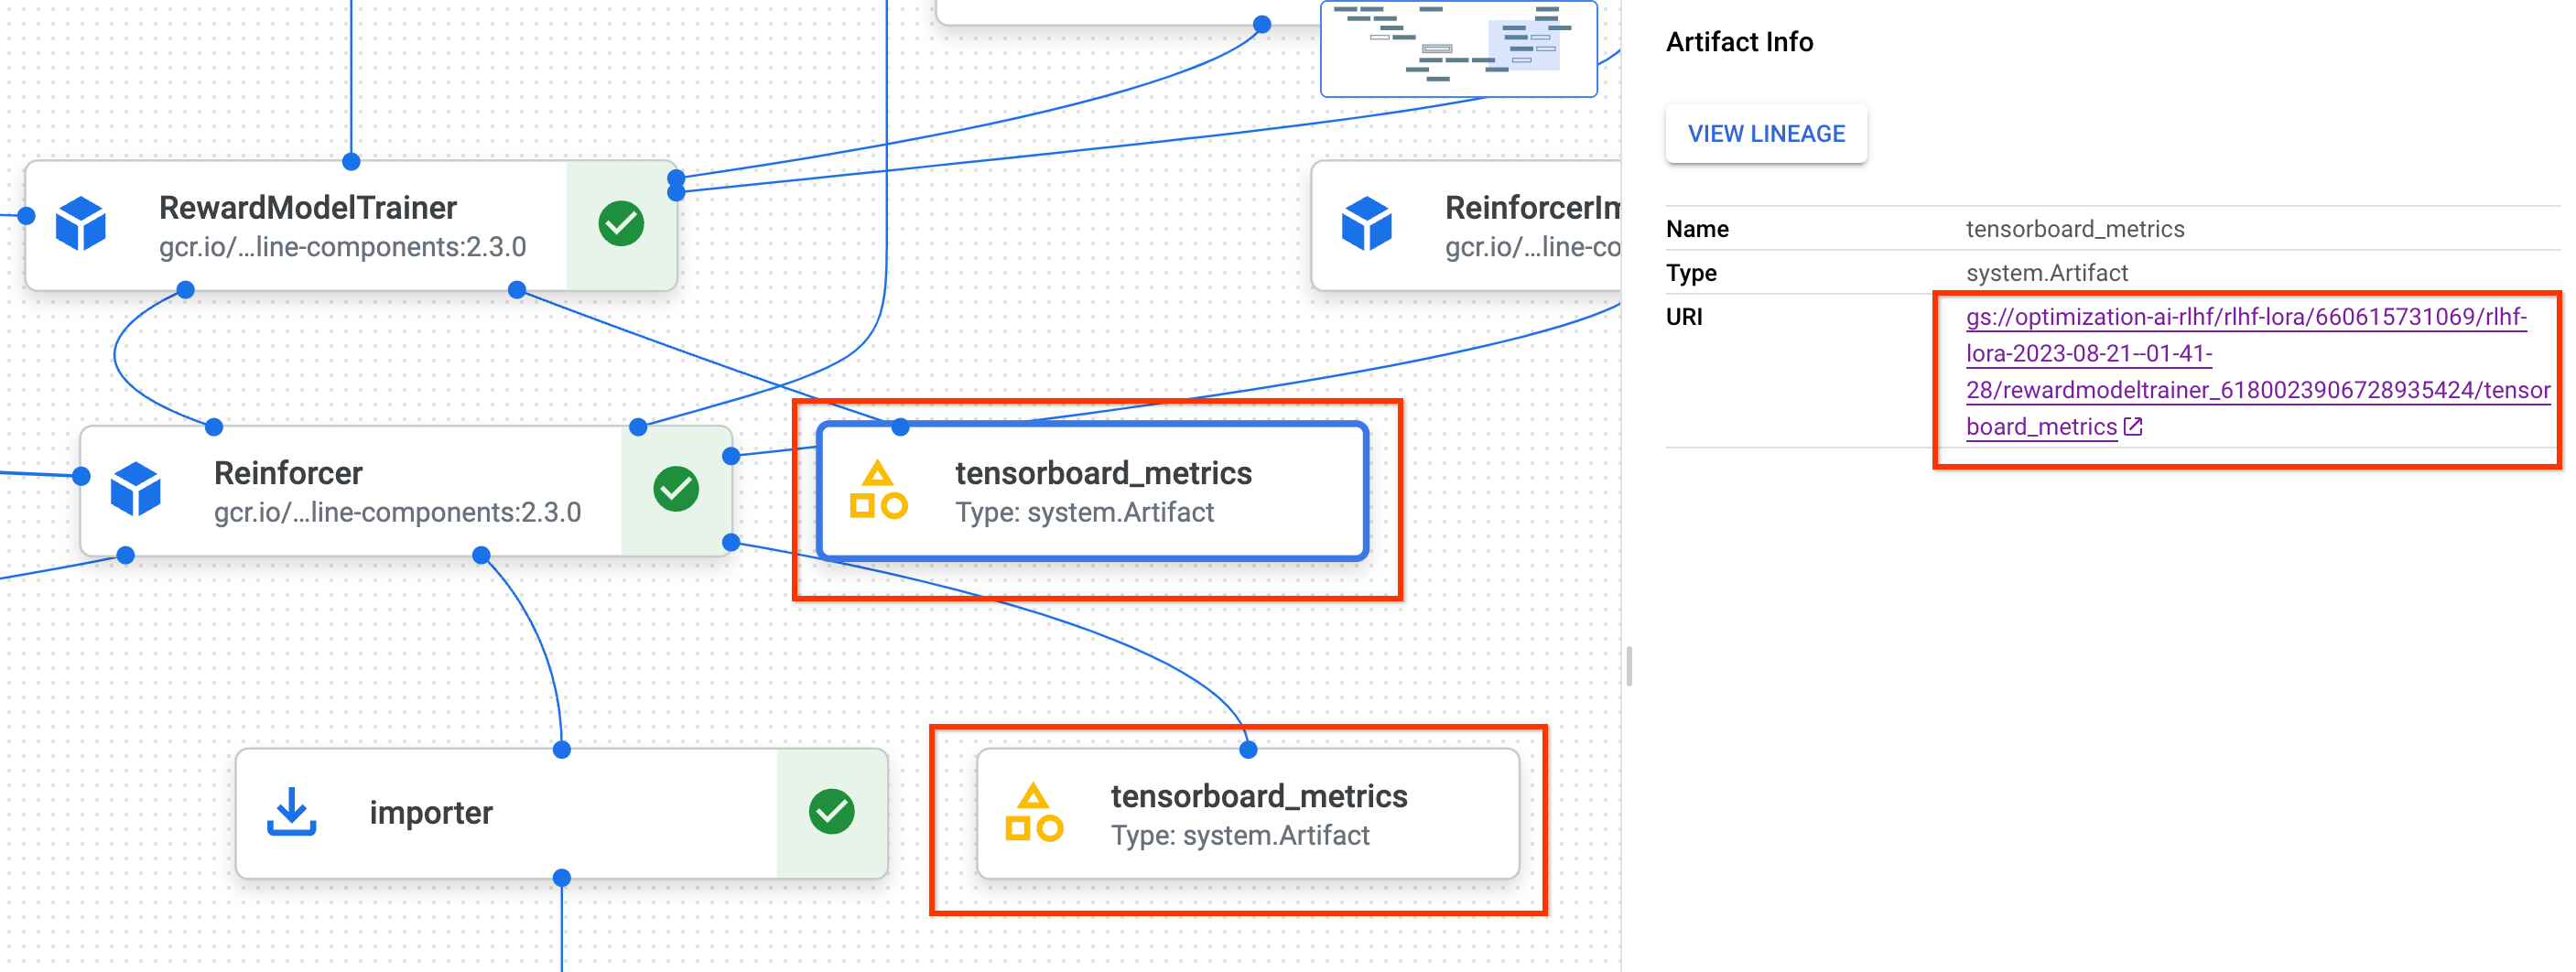

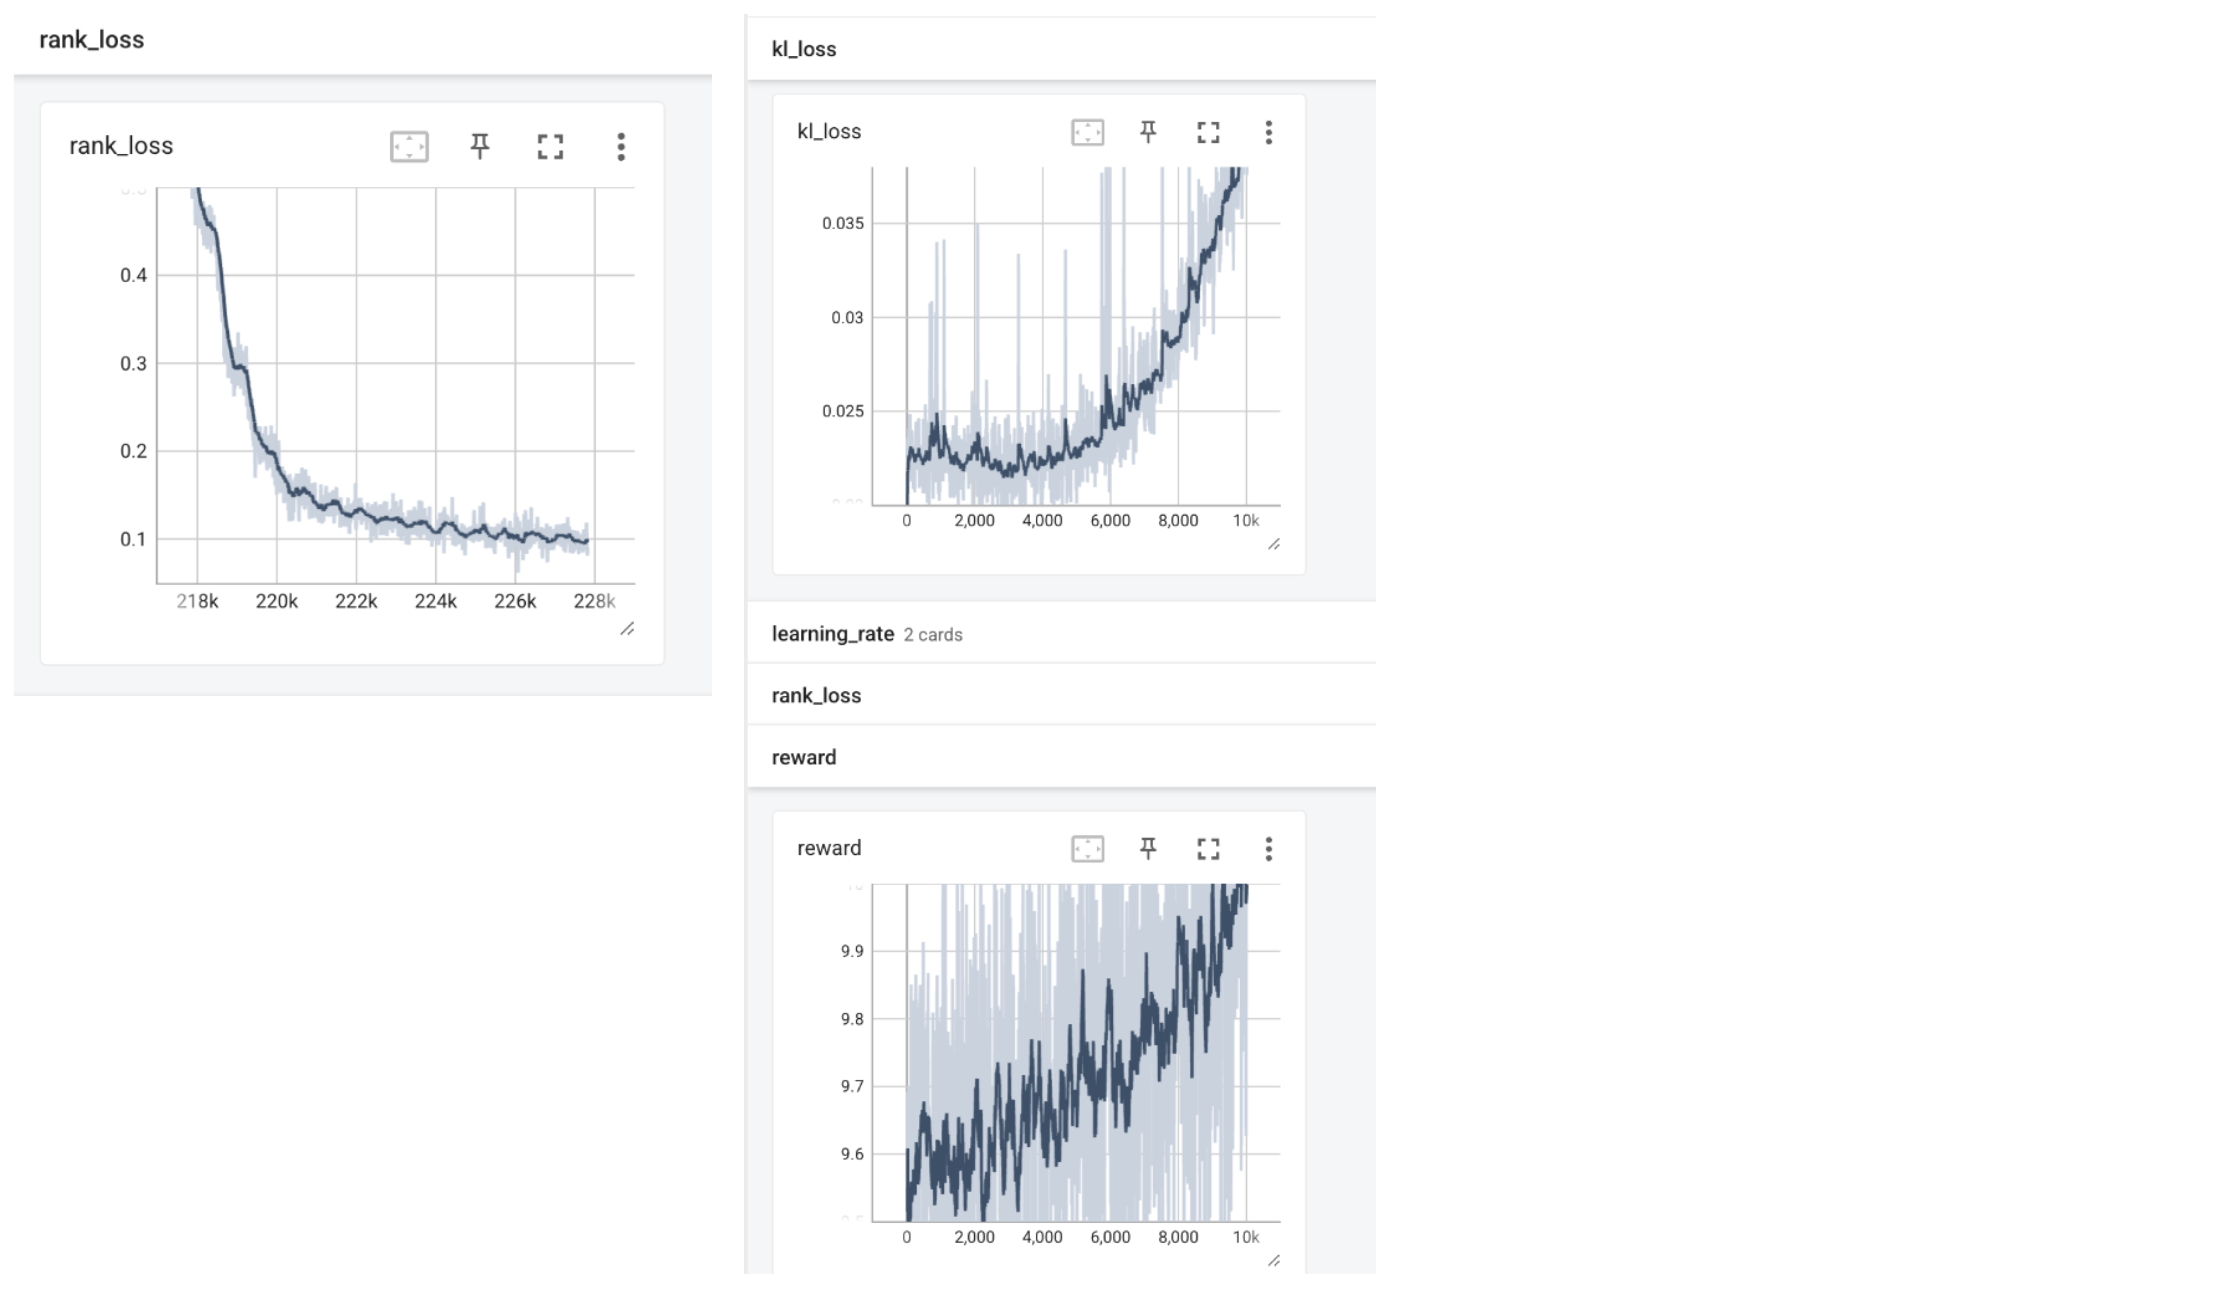

### Bulk Inference
You can perform bulk inference using your tuned model. To perform bulk inference you will need the tuned model path, which can be found in the Vertex Pipelines UI under **Reinforcer** > **Output Parameters** > `output_model_path`. See the "Bulk Inference" tutorial for more details on how to generate offline predictions from a tuned model checkpoint.

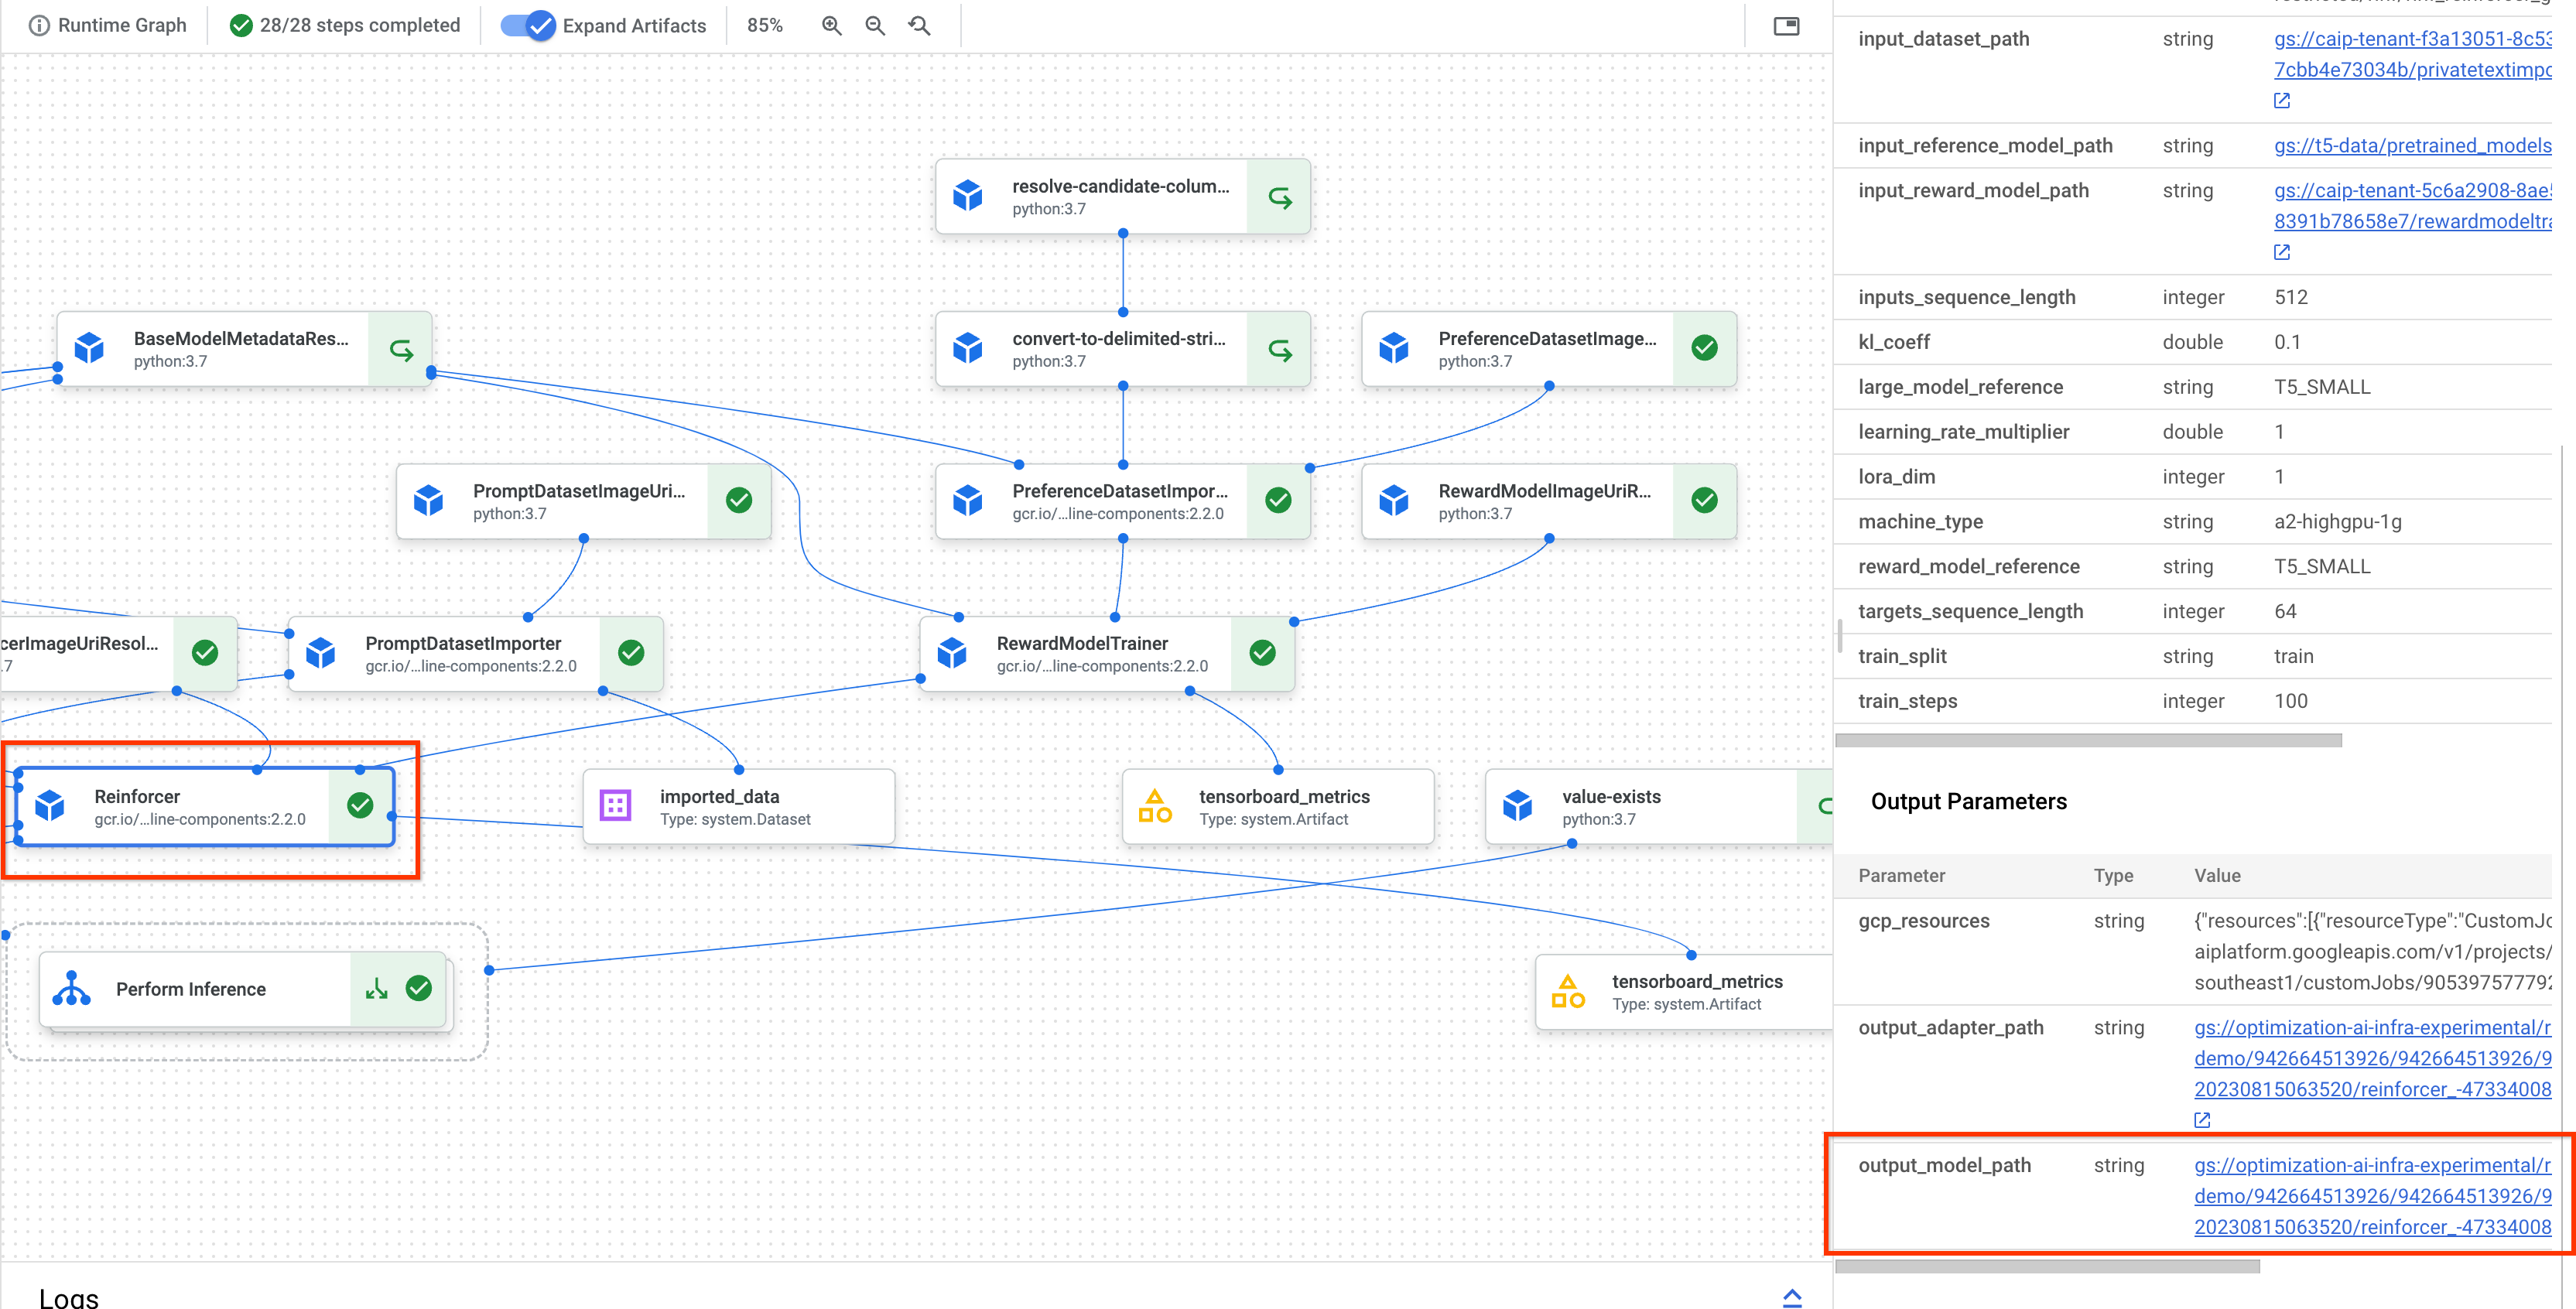

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [ ]:
import os

delete_bucket = False

job.delete()

if delete_bucket or os.getenv("ID_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}